In [1]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('https://github.com/Sputniza/data_challenges/blob/master/enriched_diversity.csv')

In [3]:
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,dept,level,people_managed
0,138719,0,273000,Master,M,2,engineering,IC,0
1,3192,0,301000,Bachelor,F,1,sales,IC,0
2,114657,0,261000,Master,F,2,sales,IC,0
3,29039,0,86000,High_School,F,4,HR,IC,0
4,118607,0,126000,Bachelor,F,3,sales,IC,0


# preprocess data

In [4]:
# dummy variables for non hierarchical values
X = pd.get_dummies(data, columns = ['sex', 'dept'])

In [5]:
X.head()

,employee_id,signing_bonus,salary,degree_level,yrs_experience,level,people_managed,sex_F,sex_M,dept_CEO,dept_HR,dept_engineering,dept_marketing,dept_sales
0,138719,0,273000,Master,2,IC,0,0,1,0,0,1,0,0
1,3192,0,301000,Bachelor,1,IC,0,1,0,0,0,0,0,1
2,114657,0,261000,Master,2,IC,0,1,0,0,0,0,0,1
3,29039,0,86000,High_School,4,IC,0,1,0,0,1,0,0,0
4,118607,0,126000,Bachelor,3,IC,0,1,0,0,0,0,0,1


In [6]:
# translate rest of categorical data with conceptual order in numerical data
X.loc[X["degree_level"] == "PhD", "degree_level"] = 3
X.loc[X["degree_level"] == "Master", "degree_level"] = 2
X.loc[X["degree_level"] == "Bachelor", "degree_level"] = 1
X.loc[X["degree_level"] == "High_School", "degree_level"] = 0
X.degree_level = X.degree_level.astype(int)

In [7]:
# level
X.loc[X["level"] == "CEO", "level"] = 5
X.loc[X["level"] == "E", "level"] = 4
X.loc[X["level"] == "VP", "level"] = 3
X.loc[X["level"] == "D", "level"] = 2
X.loc[X["level"] == "MM", "level"] = 1
X.loc[X["level"] == "IC", "level"] = 0
X.level = X.level.astype(int)

In [8]:
ID = X.pop('employee_id')

In [9]:
X.head()

,signing_bonus,salary,degree_level,yrs_experience,level,people_managed,sex_F,sex_M,dept_CEO,dept_HR,dept_engineering,dept_marketing,dept_sales
0,0,273000,2,2,0,0,0,1,0,0,1,0,0
1,0,301000,1,1,0,0,1,0,0,0,0,0,1
2,0,261000,2,2,0,0,1,0,0,0,0,0,1
3,0,86000,0,4,0,0,1,0,0,1,0,0,0
4,0,126000,1,3,0,0,1,0,0,0,0,0,1


In [10]:
y = X.pop('salary')

# Gradient Boosting

In [33]:
from sklearn.ensemble import GradientBoostingRegressor, partial_dependence as part_dep
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score

In [26]:
from seaborn import set_style
set_style("darkgrid")
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 5)

In [14]:
# Hyperparameter tuning with RandomizedSearchCV as GridSearchCV was too slow
param_dist = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
             'max_depth': [4,6],
             'min_samples_leaf': [3, 5, 9, 17],
             'max_features': [1.0, 0.3, 0.1]}
GBR = GradientBoostingRegressor(n_estimators = 3000)
rs_cv = RandomizedSearchCV(GBR, param_dist, n_iter = 10).fit(X,y)

# best parameter setting
rs_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 4,
 'max_features': 0.1,
 'min_samples_leaf': 5}

In [30]:
GBR = GradientBoostingRegressor(n_estimators = 3000, loss= 'huber', learning_rate = 0.01, max_depth = 4, max_features = 0.1, min_samples_leaf = 5 )
GBR.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=4,
             max_features=0.1, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3000, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

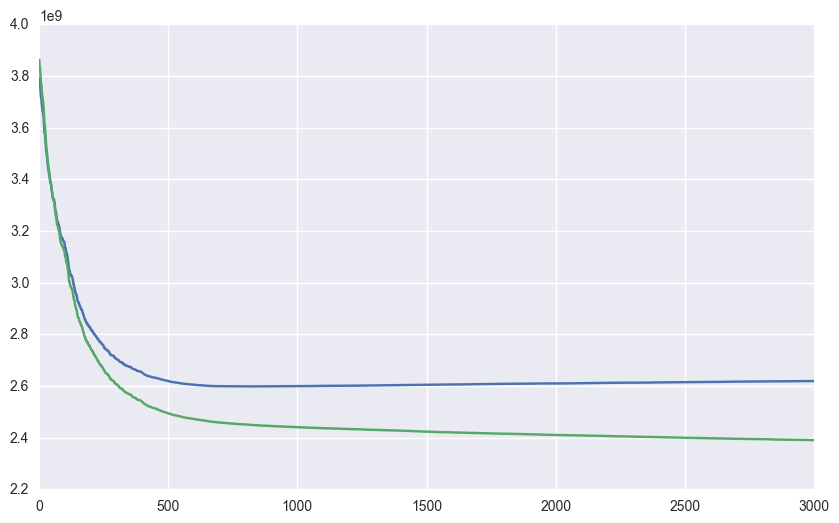

In [42]:
# tune learning rate
n_estimators = 3000
test_score = np.empty(len(GBR.estimators_))
for i, pred in enumerate (GBR.staged_predict(X_test)):
    test_score[i] = GBR.loss_(y_test, pred)

plt.plot(np.arange(n_estimators) + 1, test_score, label = 'Test')
plt.plot(np.arange(n_estimators) + 1, GBR.train_score_, label = 'Train')

In [32]:
GBR.feature_importances_

array([ 0.03683696,  0.08450893,  0.24283002,  0.08646554,  0.22991694,
        0.01816254,  0.01635266,  0.        ,  0.09664454,  0.06988436,
        0.01593397,  0.02079689])

In [34]:
r2 = r2_score(y_test, GBR.predict(X_test))
print r2

0.318186072902


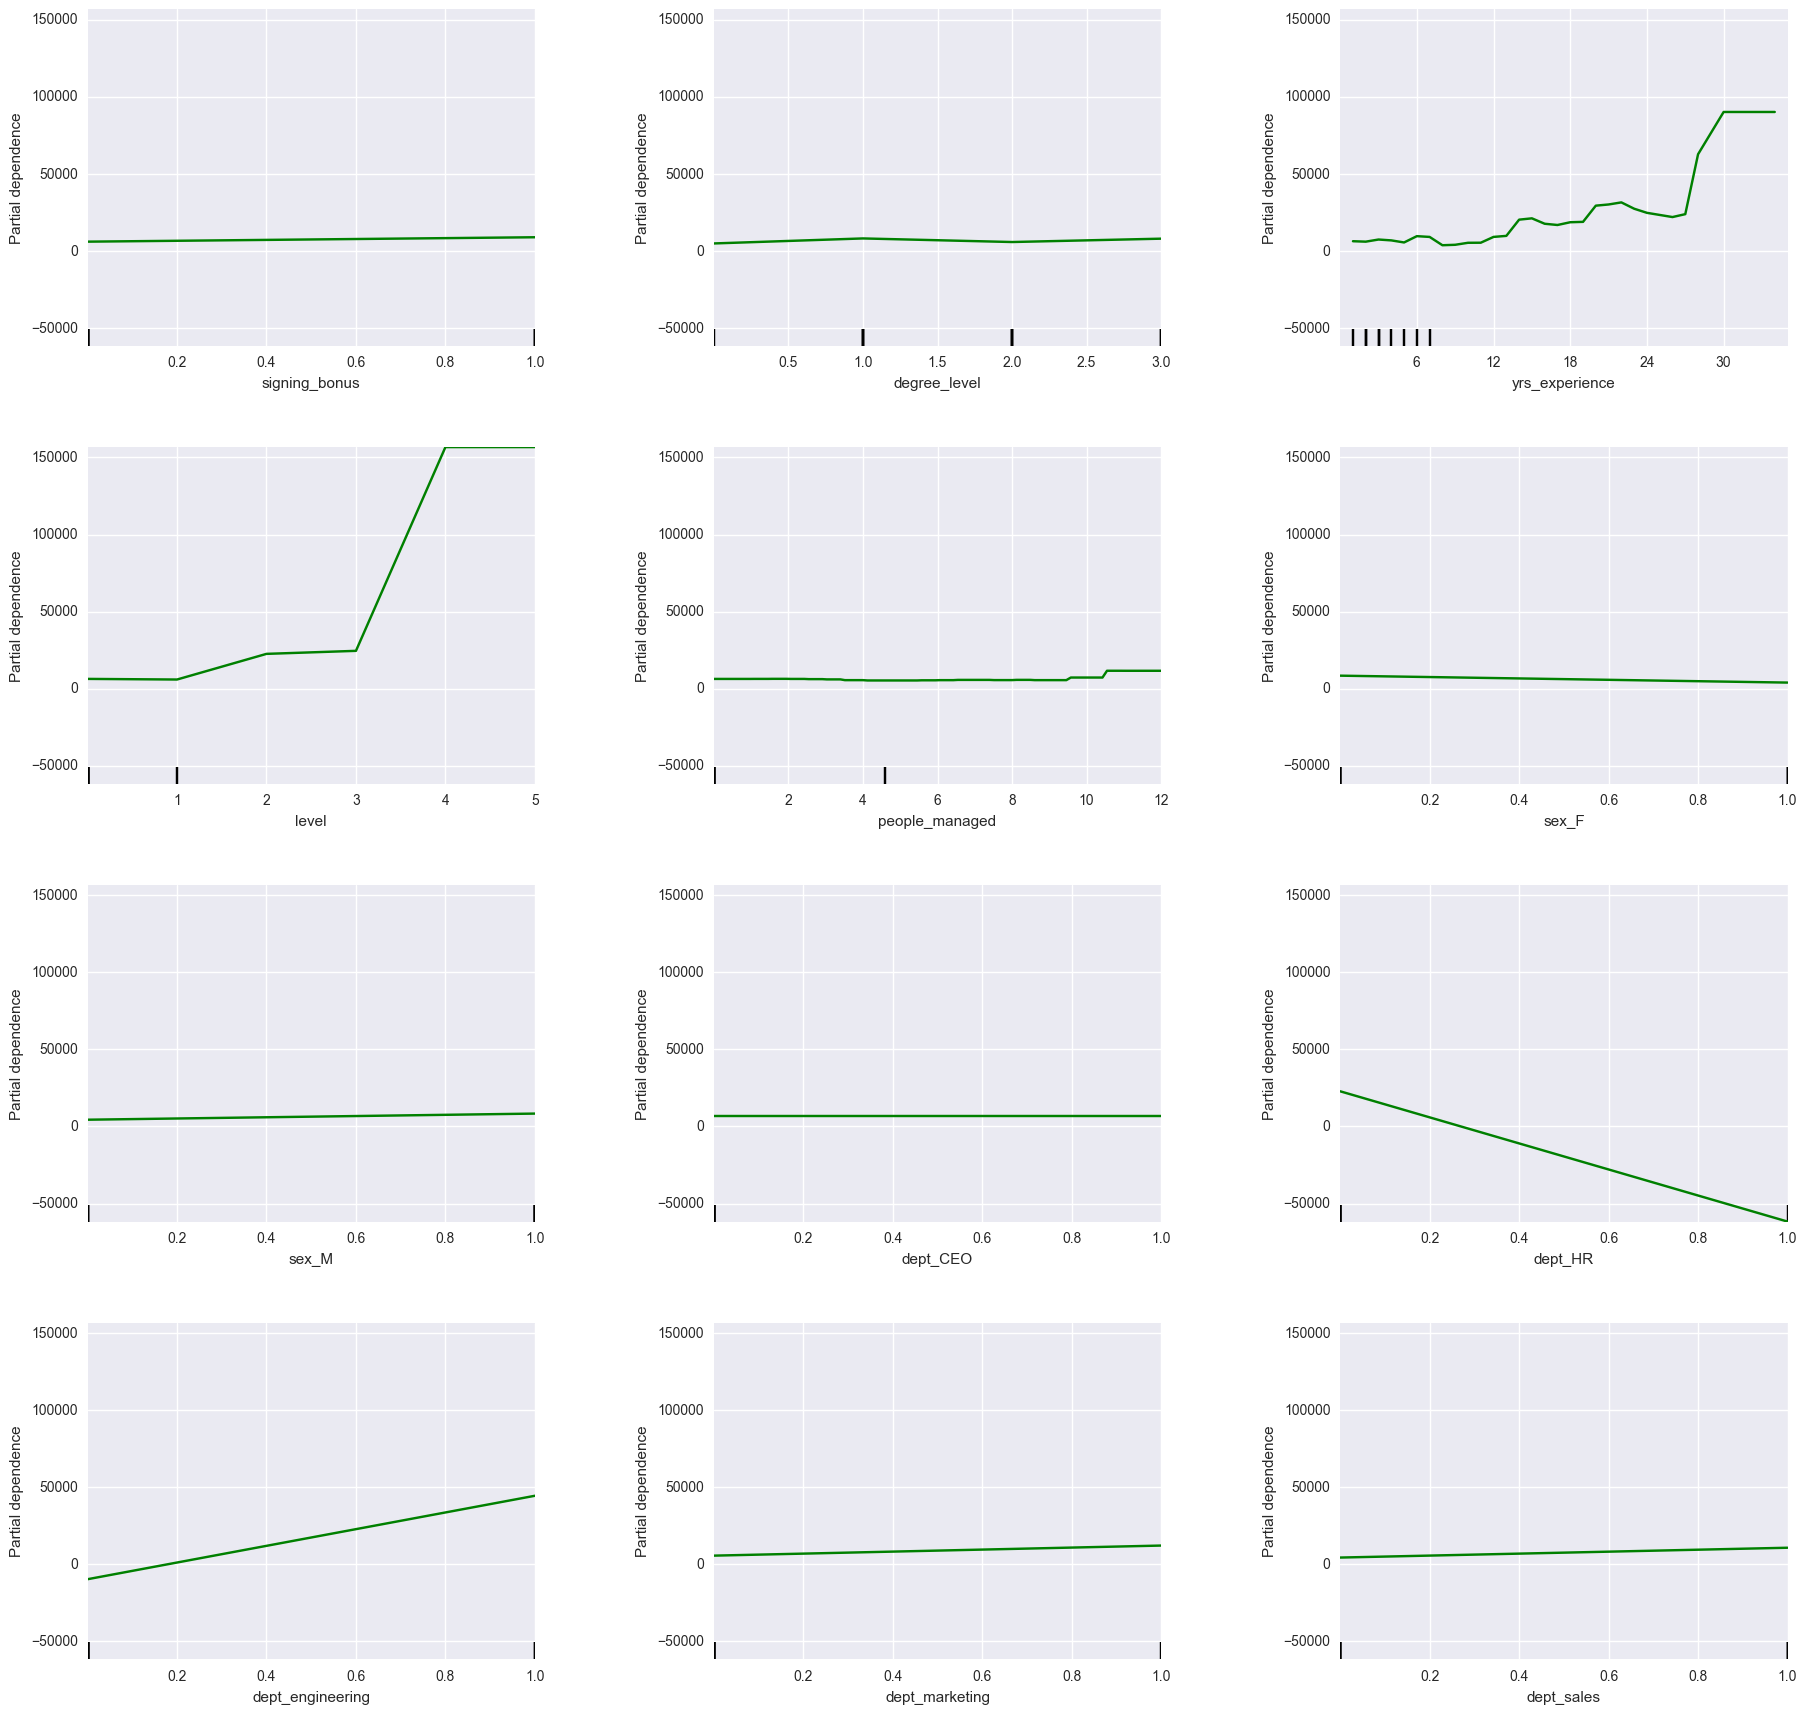

In [38]:
pylab.rcParams['figure.figsize'] = (20.0, 30.0)
features = ['signing_bonus', 'degree_level', 'yrs_experience', 'level', 'people_managed', 'sex_F', 'sex_M', 'dept_CEO', 'dept_HR', 'dept_engineering', 'dept_marketing', 'dept_sales']
fig, axs = part_dep.plot_partial_dependence(GBR, X_train, features, feature_names = features)

In [ ]:
pylab.rcParams['figure.figsize'] = (10.0, 6.0)
features = ['signing_bonus', 'degree_level', 'yrs_experience', 'level', 'people_managed', 'sex_F', 'sex_M', 'dept_CEO', 'dept_HR', 'dept_engineering', 'dept_marketing', 'dept_sales']
names = ['signing_bonus', 'degree_level', 'yrs_experience', 'level', 'people_managed', 'sex_F', 'sex_M', 'dept_CEO', 'dept_HR', 'dept_engineering', 'dept_marketing', 'dept_sales']
fig, axs = part_dep.plot_partial_dependence(GBR, X_train, features, feature_names = features)